# Clustering
## Transformation

Transforming features that are heavily skewed can help clustering algorithms (like k-means) treat them more fairly. So we'll do that first.

**Speechiness and Instrumentalness**: These features are heavily skewed towards low values. Since clustering algorithms like k-means assume roughly spherical clusters (normally distributed features), applying a logarithmic or square root transformation can help normalize the distribution.

**Liveness** is also skewed towards lower values, so we'll do a log transformation here to spread out the lower values more evenly.

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np


df = pd.read_csv('processed_data.csv')
df = df.drop(columns='loudness') ## drop loudness because it is highly correlated with energy

df['speechiness_log'] = np.log1p(df['speechiness'])  # log(1 + x) to handle zeros
df['instrumentalness_log'] = np.log1p(df['instrumentalness'])
df['liveness_log'] = np.log1p(df['liveness'])


clustering_features = ['danceability', 'energy', 'valence', 'tempo', 
                       'acousticness', 'speechiness_log', 'instrumentalness_log', 'liveness_log']

X = df[clustering_features]

## Number of clusters

Before applying k-means, it’s important to decide on the number of clusters (k). We'll use the Elbow Method to help determine an appropriate value of k.

c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

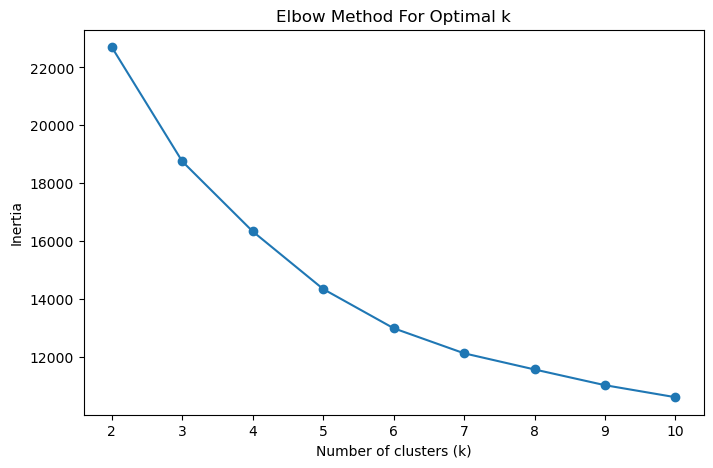

In [57]:
# Elbow method to determine optimal number of clusters
inertia = []
Krange = range(2, 14)  # Trying between 2 and 14 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot inertia to find the elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.show()



## K-Means Clustering

c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

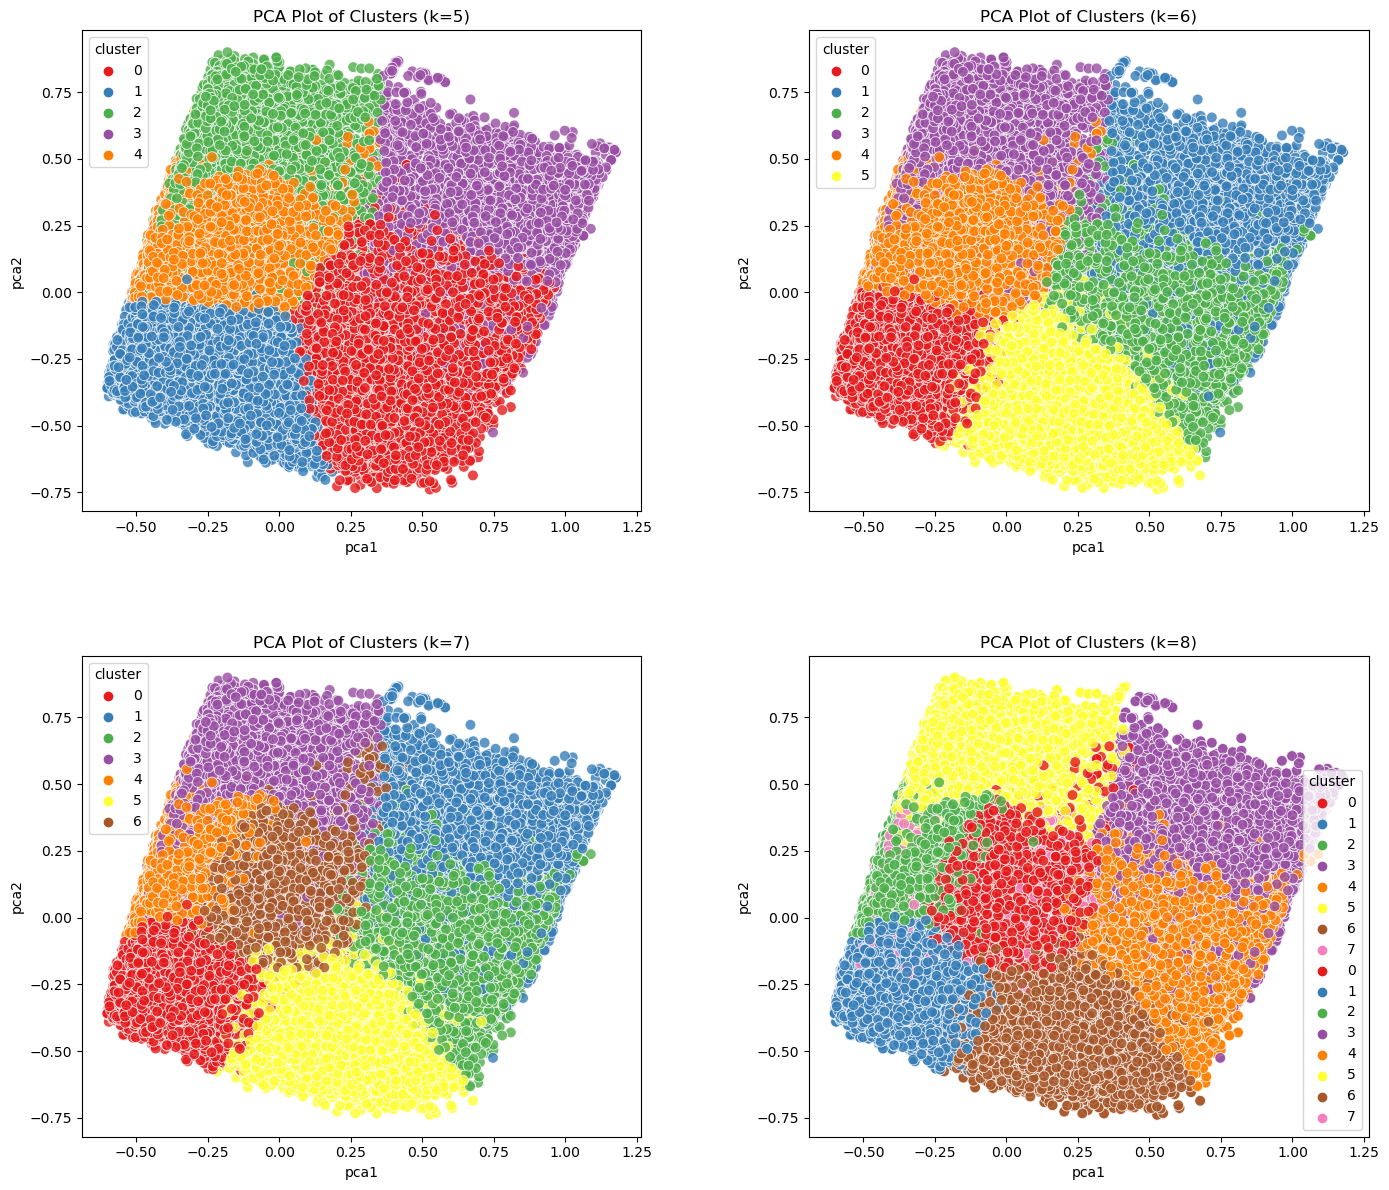

In [58]:
from sklearn.decomposition import PCA

# Apply k-means (k = 5,6,7,8. These values seems reasonable to try since is no distinct elbow)
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Reduce the dimensionality to 2D for visualization
plt.figure(figsize=(14, 12))
pca = PCA(n_components=2)
for i, k in enumerate([5, 6, 7, 8], start=1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)
    pca_components = pca.fit_transform(X)
    df['pca1'], df['pca2'] = pca_components[:, 0], pca_components[:, 1]
    plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1', s=60, alpha=0.8)
    plt.title(f'PCA Plot of Clusters (k={k})')

#Plots showing how different k-means make clusters
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set1', s=60, alpha=0.8)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()



In [59]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for each
for k in [5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print(f'Silhouette Score for k={k}: {silhouette_avg}')


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=5: 0.24004700369075518


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=6: 0.22928633209092933


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=7: 0.2210766931536136


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for k=8: 0.22275914027549576


Each color represents a distinct cluster found by the k-means algorithm. Based on the Silhouette Score we will select k=5 because it is has the best value by a bit.
The fact that the clusters form relatively distinct shapes in the PCA plot means that k-means has been successful at separating the data points into groups based on the features. Overlaps or boundary areas might indicate songs that are somewhat similar in their audio features, leading to ambiguity in their clustering.

## Cluster Means
The first table provides the mean values for each feature within each cluster. These averages tell us about the general characteristics of each cluster based on the audio features:

In [60]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)  # Assign cluster labels to the DataFrame

# Get the mean values of features for each cluster
cluster_means = df.groupby('cluster')[clustering_features].mean()
print(cluster_means)


c:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         danceability    energy   valence     tempo  acousticness  \
cluster                                                             
0            0.549833  0.419875  0.444393  0.473317      0.726734   
1            0.688348  0.746514  0.751268  0.509881      0.197261   
2            0.561796  0.767235  0.314966  0.523718      0.064744   
3            0.388870  0.203399  0.209645  0.432706      0.872587   
4            0.516724  0.770051  0.332375  0.527970      0.079380   

         speechiness_log  instrumentalness_log  liveness_log  
cluster                                                       
0               0.085904              0.017177      0.190447  
1               0.088958              0.023018      0.181841  
2               0.073573              0.565624      0.175369  
3               0.052472              0.586145      0.141843  
4               0.084032              0.020929      0.202654  


### Cluster 0:
High danceability (0.68), energy (0.77), and valence (0.73), meaning this cluster represents high-energy, upbeat, and danceable tracks.
Low acousticness (0.11), instrumentalness_log (0.02), and speechiness_log (0.09), suggesting that these are mainly non-acoustic, non-instrumental tracks with a focus on vocals.
### Cluster 1:
Low danceability (0.39), energy (0.20), and valence (0.21), representing slower, calmer, and more somber tracks.
Very high acousticness (0.87), meaning these are mostly acoustic tracks.
High instrumentalness_log (0.61), indicating a high proportion of instrumental tracks in this cluster.
### Cluster 2:
 Moderate danceability (0.50) and energy (0.33).
 High acousticness (0.76), suggesting this cluster contains more acoustic tracks.
Low valence (0.31), which implies a more somber or melancholic mood overall.
### Cluster 3:

Moderate danceability (0.56) and high energy (0.77), indicating energetic, moderately danceable tracks.
Low valence (0.31), suggesting these songs might be intense or dark.
Low acousticness (0.06) and high instrumentalness_log (0.57), meaning this cluster might represent high-energy instrumental tracks.
### Cluster 4:

Moderate danceability (0.51) and high energy (0.76), similar to cluster 3.
Low valence (0.31) and acousticness (0.08), which could represent high-energy, non-acoustic tracks, possibly in genres like electronic music.
### Cluster 5:

High danceability (0.65), energy (0.60), and valence (0.70), making it another cluster with generally upbeat, danceable tracks.
High acousticness (0.60), which is interesting given the higher energy and valence—this might indicate energetic acoustic tracks.   


## Lets look at the top 10 genres in the clusters

In [64]:
# Assuming you have a DataFrame 'df' with 'Cluster' and 'Genre' columns

# Calculate the distribution of genres in each cluster
genre_cluster_distribution = df.groupby('cluster')['track_genre'].value_counts().unstack(fill_value=0)

# Function to get top N genres for each cluster
def get_top_genres_per_cluster(cluster_distribution, top_n=10):
    top_genres = {}
    for cluster in cluster_distribution.index:
        # Sort genres by count within the cluster and get the top N
        top_genres[cluster] = cluster_distribution.loc[cluster].sort_values(ascending=False).head(top_n)
    return top_genres

# Get the top 10 genres for each cluster
top_genres = get_top_genres_per_cluster(genre_cluster_distribution, top_n=10)

# Print the top 10 genres for each cluster
for cluster, genres in top_genres.items():
    print(f"Cluster {cluster} - Top Genres:\n{genres}\n")


Cluster 0 - Top Genres:
track_genre
tango         857
comedy        844
honky-tonk    801
romance       761
cantopop      689
show-tunes    663
acoustic      624
opera         583
bluegrass     507
mandopop      493
Name: 0, dtype: int64

Cluster 1 - Top Genres:
track_genre
forro        787
salsa        775
kids         691
dancehall    676
disco        644
party        602
afrobeat     576
latin        567
dance        546
ska          535
Name: 1, dtype: int64

Cluster 2 - Top Genres:
track_genre
minimal-techno    754
detroit-techno    707
grindcore         626
black-metal       505
chicago-house     499
breakbeat         463
idm               457
trance            452
drum-and-bass     431
club              392
Name: 2, dtype: int64

Cluster 3 - Top Genres:
track_genre
new-age      772
ambient      699
sleep        652
classical    619
study        512
guitar       438
disney       431
piano        420
iranian      399
idm          302
Name: 3, dtype: int64

Cluster 4 - Top Genres:


# Clustering Analysis of Music Genres

### Cluster Descriptions

- **Cluster 0**:  
  This cluster brings together traditional, acoustic, and romantic music genres, including **tango**, **honky-tonk**, and **opera**. With show tunes and acoustic tracks, it has a theatrical and emotional feel. The presence of Asian pop genres like **Cantopop** and **Mandopop** suggests an international influence, while **comedy** adds a light-hearted element.

- **Cluster 1**:  
  This group is vibrant and upbeat, featuring dance and party-friendly genres like **salsa**, **dancehall**, and **disco**. **Afrobeat**, **ska**, and **Latin** music add to the lively, rhythmic vibe, making this cluster ideal for social gatherings and celebratory settings. The inclusion of **kids** music suggests appeal for younger audiences as well.

- **Cluster 2**:  
  Known for high-energy and intense genres, this cluster combines electronic, techno, and metal influences. Genres like **minimal-techno**, **grindcore**, and **drum-and-bass** highlight its fast tempo and aggressive sound, catering to fans of electronic dance music (EDM) and metal subgenres, likely attracting high-energy events or club environments.

- **Cluster 3**:  
  A calm and relaxing group, this cluster includes **ambient**, **new-age**, and **classical** music, ideal for sleep, study, and meditation. The addition of instrumental genres like **guitar** and **piano**, along with **Disney**, provides a soothing or child-friendly atmosphere, suitable for unwinding or focusing.

- **Cluster 4**:  
  Dominated by rock and metal genres such as **heavy-metal**, **grunge**, and **death-metal**, this cluster has an intense, heavy sound. **Industrial** and **emo** genres add an emotional edge, while **world music** and **dub** introduce a unique global flair, but the overall feel remains gritty and aggressive.

---

### Summary of Cluster Characteristics

- **Cluster 0**: Romantic and acoustic, featuring tango, opera, and show tunes.
- **Cluster 1**: Upbeat and dance-focused, with salsa, dancehall, and disco.
- **Cluster 2**: High-energy electronic, with techno and drum-and-bass.
- **Cluster 3**: Calm and instrumental, including ambient and classical.
- **Cluster 4**: Heavy and aggressive, with metal and grunge genres.


In [67]:
# Labelize the clusters

cluster_labels = {
    0: 'Romantic & Acoustic Music',
    1: 'Upbeat Dance & Party Music',
    2: 'High-energy Electronic & Intense Music',
    3: 'Calm & Relaxing Instrumentals',
    4: 'Heavy Metal & Aggressive Rock'
}


# Create a new column in the dataframe for these labels
df['cluster_label'] = df['cluster'].map(cluster_labels)

# Check the first few rows to ensure the labels are added
df[['cluster', 'cluster_label']].head()


,cluster,cluster_label
0,1,Upbeat Dance & Party Music
1,0,Romantic & Acoustic Music
2,4,Heavy Metal & Aggressive Rock
3,0,Romantic & Acoustic Music
4,0,Romantic & Acoustic Music


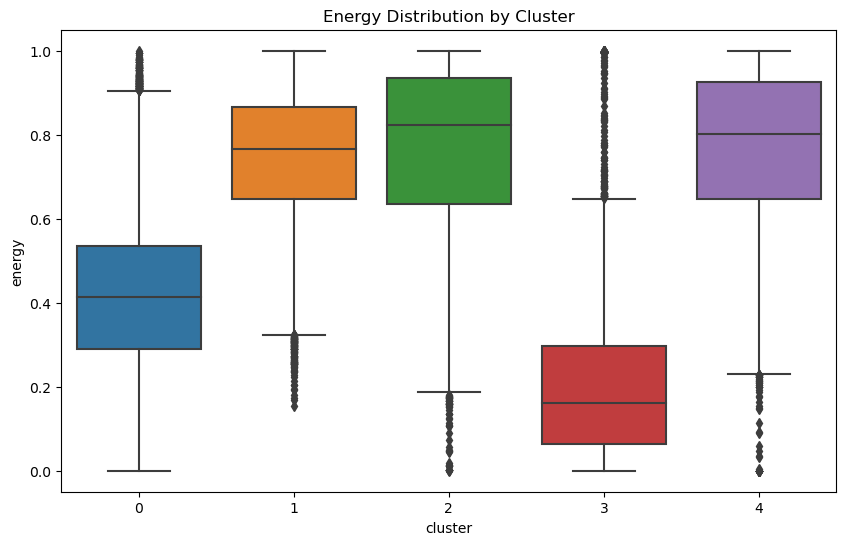

In [69]:
# Box plot of features by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster', y='energy')
plt.title('Energy Distribution by Cluster')
plt.show()
